# Deploy Stable Diffusion on a SageMaker GPU Multi-Model Endpoint with Triton

본 예제 코드는 AWS 공식 예제를 바탕으로 튜토리얼 코드를 추가하고 conda 가상 환경에서 사용자 정의 도커 컨테이너를 빌드하여 호스팅하는 방법으로 변경하였습니다.

<br>

### 1. Installs and imports 
---

In [ ]:
%pip install -qU sagemaker pillow huggingface-hub

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role

import time
import json
import base64
import jinja2
import numpy as np
from PIL import Image
from io import BytesIO
from IPython.display import display

from utils.lib import download_model, get_triton_image_uri
from pathlib import Path

# variables
s3_client = boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker variables
role = get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
bucket = sagemaker_session.default_bucket()
account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.Session().region_name
prefix = "stable-diffusion-mme"

jinja_env = jinja2.Environment()

<br>

### 2. Save pretrained model
---

`models` 디렉터리는 Triton Inference Server의 모델 리포지터리(model repository)를 의미합니다. 이 리포지토리의 각 하위 디렉토리는 해당 모델에 대한 설정 정보(`config.pbtxt`)와 모델(프레임워크 및 백엔드에 따라 모델 추론 코드나 모델 파라메터)을 아래와 같이 포함하고 있습니다.

```
<model-repository-path>/
    <model-1-name>/
        [config.pbtxt]
        [<output-labels-file> ...]
        <version>/
            <model-definition-file>
        <version>/
            <model-definition-file>
        ...
    <model-2-name>/
        [config.pbtxt]
        [<output-labels-file> ...]
        <version>/
            <model-definition-file>
        <version>/
            <model-definition-file>
        ...
    ...
```

- Python: `model.py`
- TorchScript: `model.pt`
- TensorRT: `model.plan`
- ONNX: `model.onnx`
- TensorFlow: `model.graphdef`나 `model.savedmodel` 이름의 폴더


본 예시에서는 파이썬 백엔드를 사용합니다.

### config.pbtxt 개요
backend, max_batch_size, input 및 output 등의 항목을 `config.pbtxt`에 작성합니다..

- backend : 사용 프레임워크/백엔드 (예: "tensorrt", "python", "onnxruntime", "tensorflow", "pytorch")
- platform : 모델 포맷 (예: "tensorrt_plan", "tensorflow_savedmodel", "tensorflow_graphdef")
- max_batch_size : 클라이언트 혹은 Triton이 구성할 수 있는 dynamic batch size의 최댓값
- input : 입력 tensor의 이름, data type 및 shape
- output : 출력 tensor의 이름, data type 및 shape

예시 

```
backend: "onnxruntime"
max_batch_size: 8
input [
  {
    name: "input0"
    data_type: TYPE_FP32
    dims: [ 224, 224, 3 ]
  }
]
output [
  {
    name: "output0"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
]
```


In [3]:
models_local_path = {
    "stabilityai/stable-diffusion-2-1-base": "models/sd_base/1/checkpoint",
    "stabilityai/stable-diffusion-2-depth": "models/sd_depth/1/checkpoint",
    "stabilityai/stable-diffusion-2-inpainting": "models/sd_inpaint/1/checkpoint",
    "stabilityai/stable-diffusion-x4-upscaler": "models/sd_upscale/1/checkpoint",
}

for model_name, model_local_path in models_local_path.items():
    download_model(model_name, model_local_path)

models/sd_base/1/checkpoint
Hugging Face model already exists! - [HF_MODEL_ID] stabilityai/stable-diffusion-2-1-base
models/sd_depth/1/checkpoint
Hugging Face model already exists! - [HF_MODEL_ID] stabilityai/stable-diffusion-2-depth
models/sd_inpaint/1/checkpoint
Hugging Face model already exists! - [HF_MODEL_ID] stabilityai/stable-diffusion-2-inpainting
models/sd_upscale/1/checkpoint
Hugging Face model already exists! - [HF_MODEL_ID] stabilityai/stable-diffusion-x4-upscaler


<br>

## 3. Create Docker image and push it to ECR
---

파이썬 백엔드를 사용하는 경우 종속 패키지를 사용해야 하는 경우가 빈번하므로 conda pack을 사용한 자체 가상 환경이나 도커(docker) 이미지를 생성해야 합니다. AWS 공식 예제에서는 자체 가상 환경으로 모델을 배포하지만, 이 경우 단일 인스턴스 배포로만 제한되기에 오토스케일링을 적용할 수 없습니다. 따라서, 사용자 정의 도커 이미지를 생성해서 ECR()에 푸시하도록 하겠습니다.


### Create Dockerfile

사용자 정의 도커 이미지 생성 시, AWS에서 관리하는 도커 이미지를 베이스 이미지로 사용하는 것을 권장합니다. 아래 웹페이지를 참조하세요.
- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

In [5]:
triton_image_uri, triton_account_id = get_triton_image_uri()
print(f'triton_image_uri: {triton_image_uri}')

triton_image_uri: 785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:23.05-py3


In [6]:
%%writefile docker/Dockerfile

FROM {{triton_image_uri}}
RUN pip install -U pip && \
    pip install --no-cache-dir sagemaker \
    boto3 \
    torch --extra-index-url https://download.pytorch.org/whl/cu118 \
    accelerate \
    transformers \
    diffusers \
    xformers

ENV PYTHONUNBUFFERED=TRUE

Overwriting docker/Dockerfile


In [7]:
template = jinja_env.from_string(Path("docker/Dockerfile").open().read())
Path("docker/Dockerfile").open("w").write(template.render(triton_image_uri=triton_image_uri))
!pygmentize docker/Dockerfile | cat -n

     1	FROM 785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:23.05-py3
     2	RUN pip install -U pip && \
     3	    pip install --no-cache-dir sagemaker \
     4	    boto3 \
     5	    torch --extra-index-url https://download.pytorch.org/whl/cu118 \
     6	    accelerate \
     7	    transformers \
     8	    diffusers \
     9	    xformers
    10	
    11	ENV PYTHONUNBUFFERED=TRUE


### Create script file for building and pushing

In [9]:
%%writefile build_and_push.sh
#!/usr/bin/env bash

# This script builds Docker container and pushes it to ECR, 
# so it is available for training and inference in Amazon Sagemaker.

# Script takes 3 arguments:
#    - image - required, this is container name which will be used when building locally and pushing to Amazon ECR;
#    - tag - optional, if provided, it will be used as ":tag" of your container name; otherwise, ":latest" will be used;
#    - dockerfile - optional, if provided, then docker will build container using specific dockerfile (e.g. "Dockerfile.serving"); otherwise, default "Dockerfile" will be used.

# Usage examples:
#    1. "./build_and_push.sh d2-sm-coco-serving debug Dockerfile.serving"
#    2. "./build_and_push.sh d2-sm-coco v2"

image=$1
tag=$2
dockerfile=$3

if [ "$image" == "" ]
then
    echo "Usage: $0 <image-name>"
    exit 1
fi

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi

# Get the region defined in the current configuration (default to us-east-2 if none defined)
region=$(aws configure get region)

if [ "$tag" == "" ]
then
    fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}:latest"
else
    fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}:${tag}"
fi

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${image}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${image}" > /dev/null
fi

# Get the login command from ECR and execute it directly (자신의 ECR 권한)
$(aws ecr get-login --region ${region} --no-include-email)

# Get public ECR access (해당 부분은 docker build 스크립트에서 사용하는 public ECR주소로 바꿔주어야 함)
aws ecr get-login-password --region ${region} | docker login --username AWS --password-stdin {{triton_account_id}}.dkr.ecr.${region}.amazonaws.com

if [ "$dockerfile" == "" ]
then
    docker build  -t ${image} .
else
    docker build -t ${image} . -f ${dockerfile}
fi

docker tag ${image} ${fullname}
docker push ${fullname}

Overwriting build_and_push.sh


In [10]:
template = jinja_env.from_string(Path("build_and_push.sh").open().read())
Path("build_and_push.sh").open("w").write(template.render(triton_account_id=triton_account_id))
#!pygmentize build_and_push.sh | cat -n
!chmod +x build_and_push.sh

### Build docker image and push it to ECR 

도커 이미지를 빌드하고 ECR에 푸시하는 데 몇 분의 시간이 소요됩니다. 

In [11]:
container = "js-onboarding-mme"
tag = "latest"
ecr_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{container}:{tag}"
#! ./build_and_push.sh $container $tag docker/Dockerfile

### (Optional) 4. Debugging in local development environment

SageMaker 엔드포인트를 배포하기 이전에 로컬 환경에서 테스트해볼 수 있습니다. 

- Triton 서버 구동: 아래 코드 셀에서 생성되는 `start_tritonserver.sh` 을 터미널에서 실행
- Triton 클라이언트로 추론 수행: `2_simple-test-tritonclient.ipynb` 실행

도커 컨테이너를 중단하고 이미지를 삭제하려면 `docker rm -f $(docker ps -qa)` 커맨드를 입력합니다.

In [ ]:
%%writefile start_tritonserver.sh
docker run --gpus=1 --rm -p8000:8000 -p8001:8001 -p8002:8002 \
    -v {{root_dir}}/models:/models {{ecr_image_uri}} tritonserver \
    --model-repository=/models --model-control-mode=explicit --load-model=sd_base \
    --log-verbose=3 --log-info=1 --log-warning=1 --log-error=1

In [ ]:
template = jinja_env.from_string(Path("start_tritonserver.sh").open().read())
Path("start_tritonserver.sh").open("w").write(template.render(root_dir=os.getcwd(), ecr_image_uri=ecr_image_uri))
!pygmentize start_tritonserver.sh | cat -n
!chmod +x start_tritonserver.sh

터미널(Terminal) 접속 후 `start_tritonserver.sh`를 실행하면 Triton 추론 서버 컨테이너가 실행됩니다. `2_simple-test-tritonclient.ipynb` 파일을 열어서 추른을 수행해 보세요.

<br>

## 4. Model upload to S3
---

In [ ]:
model_root_path = Path("./models")
model_dirs = list(model_root_path.glob("*"))
model_upload_paths = {}

for model_path in model_dirs:
    model_name = model_path.name
    tar_name = model_path.name + ".tar.gz"
    !tar -C $model_root_path -czvf $tar_name $model_name
    model_upload_paths[model_name] = sagemaker_session.upload_data(path=tar_name, bucket=bucket, key_prefix=prefix)
    !rm $tar_name

<br>

## 5. SageMaker Endpoint (Local Mode)
---

로컬 모드는 필수로 수행할 필요는 없지만, 디버깅에 많은 도움이 됩니다. 다만, MME는 로컬 모드 구동 시 단일 모델만 로드되므로 `triton_env` 변수를 테스트하고자 하는 모델로 변경해 주시기 바립니다. (`"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "[YOUR-MODEL]"`)

또한, 로컬 모드 사용 시에는 모델을 S3에 반드시 업로드할 필요 없이 로컬 디렉터리에서도 로드할 수 있습니다. (`local_container` 변수 참조)

### MME configure

In [14]:
triton_env = {
    "SAGEMAKER_TRITON_LOG_VERBOSE": "3",
    "SAGEMAKER_TRITON_LOG_INFO": "1",
    "SAGEMAKER_TRITON_LOG_WARNING" : "1",
    "SAGEMAKER_TRITON_LOG_ERROR" : "1",
    "SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "sd_base"
}

model_data_url = f"s3://{bucket}/{prefix}/"  # s3 location where models are stored

container = {
    "Image": ecr_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
    "Environment": triton_env
}

local_container = {
    "Image": ecr_image_uri,
    "ModelDataUrl": f"{model_data_url}sd_base.tar.gz",
    "Environment": triton_env
}

In [15]:
# Set to True to enable SageMaker to run locally
local_mode = True

if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
else:
    instance_type = "ml.g5.2xlarge"
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")

instance_count = 1
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{prefix}-mdl-{ts}"
endpoint_config_name = f"{prefix}-epc-{ts}"
endpoint_name = f"{prefix}-ep-{ts}"

### Create Endpoint

In [16]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)
#print("Model Arn: " + create_model_response["ModelArn"])

엔드포인트 생성까지 몇 분의 시간이 소요됩니다. 로컬 모드 사용 시에 도커 이미지가 저장되어 있다면, SageMaker 호스팅 인스턴스를 프로비저닝하고 도커 이미지를 다운로드하는 과정이 생략되므로 호스팅 환경보다 좀 더 빨리 배포됩니다.

In [17]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

Attaching to d3wue5cfq1-algo-1-piaxu
d3wue5cfq1-algo-1-piaxu  | 
d3wue5cfq1-algo-1-piaxu  | =============================
d3wue5cfq1-algo-1-piaxu  | == Triton Inference Server ==
d3wue5cfq1-algo-1-piaxu  | =============================
d3wue5cfq1-algo-1-piaxu  | 
d3wue5cfq1-algo-1-piaxu  | NVIDIA Release 23.05 (build <unknown>)
d3wue5cfq1-algo-1-piaxu  | Triton Server Version 2.34.0
d3wue5cfq1-algo-1-piaxu  | 
d3wue5cfq1-algo-1-piaxu  | Copyright (c) 2018-2023, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
d3wue5cfq1-algo-1-piaxu  | 
d3wue5cfq1-algo-1-piaxu  | Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
d3wue5cfq1-algo-1-piaxu  | 
d3wue5cfq1-algo-1-piaxu  | This container image and its contents are governed by the NVIDIA Deep Learning Container License.
d3wue5cfq1-algo-1-piaxu  | By pulling and using the container, you accept the terms and conditions of this license:
d3wue5cfq1-algo-1-piaxu  | https://developer.nvidia.com/ngc/

모델 서빙을 위한 도커 컨테이너가 구동되고 있음을 확인할 수 있습니다.

In [19]:
!docker ps

CONTAINER ID   IMAGE                                                                   COMMAND                  CREATED          STATUS          PORTS                                       NAMES
d988f9df2e91   143656149352.dkr.ecr.us-east-1.amazonaws.com/js-onboarding-mme:latest   "/opt/nvidia/nvidia_…"   36 seconds ago   Up 34 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp   d3wue5cfq1-algo-1-piaxu


### Inference test

In [20]:
from utils.inference_lib import get_sample_binary, encode_image, decode_image

In [32]:
def invoke_endpoint(endpoint_name, payload, target_model):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
        TargetModel=target_model,
    )
    data = response["Body"].read().decode("utf-8")
    output = json.loads(data)["outputs"]
    output_image = decode_image(output[0]["data"][0])
    return output_image

def invoke_endpoint_binary_json(endpoint_name, payload, target_model):
    request_body, header_length = get_sample_binary(payload)
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
            header_length
        ),
        Body=request_body,
        TargetModel=target_model
    )

    data = response["Body"].read()
    ptn = re.compile(rb'\{"binary_data_size":[0-9]*\}')
    match = json.loads(ptn.search(r).group().decode('utf-8'))
    binary_data_size = match['binary_data_size']
    binary_data = response_body[len(response_body)-binary_data_size:]
    output_image = decode_image(binary_data)
    return output_image

In [ ]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

d3wue5cfq1-algo-1-piaxu  | I0814 23:05:15.154634 95 sagemaker_server.cc:190] SageMaker request: 2 /invocations
d3wue5cfq1-algo-1-piaxu  | I0814 23:05:15.154676 95 model_lifecycle.cc:328] GetModel() '/opt/ml/model/::sd_base' version -1
d3wue5cfq1-algo-1-piaxu  | I0814 23:05:15.154687 95 model_lifecycle.cc:328] GetModel() '/opt/ml/model/::sd_base' version -1
d3wue5cfq1-algo-1-piaxu  | I0814 23:05:15.154736 95 infer_request.cc:751] [request id: <id_unknown>] prepared: [0x0x7f315c005ee0] request id: , model: sd_base, requested version: -1, actual version: 1, flags: 0x0, correlation id: 0, batch size: 1, priority: 0, timeout (us): 0
d3wue5cfq1-algo-1-piaxu  | original inputs:
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c006558] input: negative_prompt, type: BYTES, original shape: [1,1], batch + shape: [1,1], shape: [1]
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c006688] input: gen_args, type: BYTES, original shape: [1,1], batch + shape: [1,1], shape: [1]
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c0063c8] inp

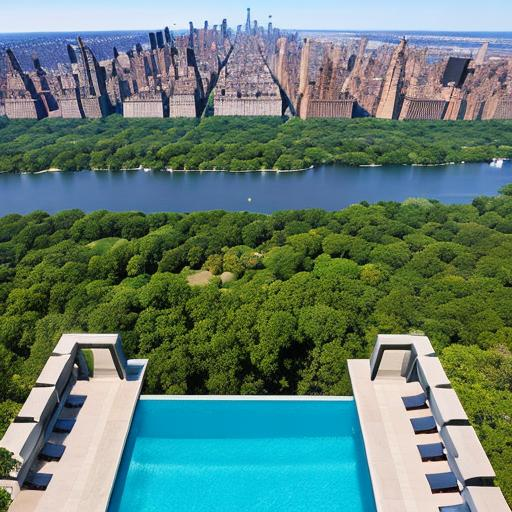

In [33]:
invoke_endpoint(endpoint_name, payload, target_model="sd_base.tar.gz")

d3wue5cfq1-algo-1-piaxu  | I0814 23:03:36.621825 95 sagemaker_server.cc:190] SageMaker request: 2 /invocations
d3wue5cfq1-algo-1-piaxu  | I0814 23:03:36.621862 95 model_lifecycle.cc:328] GetModel() '/opt/ml/model/::sd_base' version -1
d3wue5cfq1-algo-1-piaxu  | I0814 23:03:36.621881 95 model_lifecycle.cc:328] GetModel() '/opt/ml/model/::sd_base' version -1
d3wue5cfq1-algo-1-piaxu  | I0814 23:03:36.621932 95 infer_request.cc:751] [request id: <id_unknown>] prepared: [0x0x7f315c005300] request id: , model: sd_base, requested version: -1, actual version: 1, flags: 0x0, correlation id: 0, batch size: 1, priority: 0, timeout (us): 0
d3wue5cfq1-algo-1-piaxu  | original inputs:
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c005948] input: negative_prompt, type: BYTES, original shape: [1,1], batch + shape: [1,1], shape: [1]
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c005a48] input: gen_args, type: BYTES, original shape: [1,1], batch + shape: [1,1], shape: [1]
d3wue5cfq1-algo-1-piaxu  | [0x0x7f315c0057e8] inp

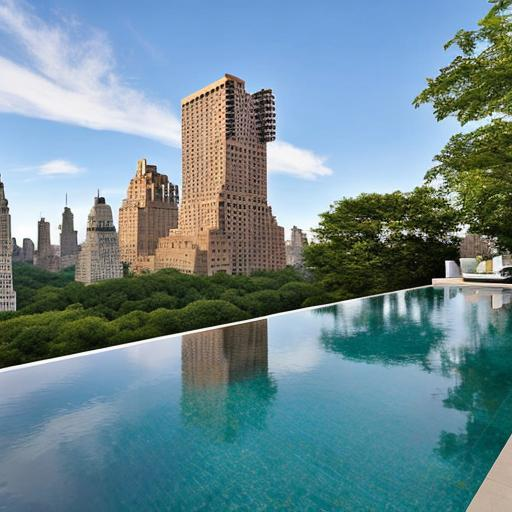

In [31]:
invoke_endpoint_binary_json(endpoint_name, payload, target_model="sd_base.tar.gz")

### Delete Endpoint 

In [36]:
from utils.lib import delete_endpoint
delete_endpoint(sm_client, endpoint_name)
!sudo rm -rf /tmp/tmp*

Gracefully stopping... (press Ctrl+C again to force)


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 862, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 928, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 130

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 867, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp656sauuh/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process

--- Deleted model: stable-diffusion-mme-mdl-2023-08-14-22-53-59
--- Deleted endpoint_config: stable-diffusion-mme-epc-2023-08-14-22-53-59
--- Deleted endpoint: stable-diffusion-mme-ep-2023-08-14-22-53-59


Create a SageMaker endpoint configuration.

<br>

## 6. SageMaker Endpoint (Hosting)
---

SageMaker 엔드포인트는 REST API를 통해 실시간 추론(real-time inference)을 수행하는 완전 관리형 서비스입니다. 기본적으로 분산 컨테이너로 고가용성, 다중 모델 로딩, A/B 테스트를 위한 인프라 환경(EC2, 로드밸런서, 오토스케일링, 모델 아티팩트 로딩 등)이 사전 구축되어 있기에 몇 줄의 코드만으로 엔드포인트가 자동으로 생성되기에, 모델을 프로덕션에 빠르게 배포할 수 있습니다.

In [37]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
else:
    instance_type = "ml.g5.2xlarge"
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")

instance_count = 1
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{prefix}-mdl-{ts}"
endpoint_config_name = f"{prefix}-epc-{ts}"
endpoint_name = f"{prefix}-ep-{ts}"

### Create Endpoint

In [41]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)
print("Model Arn: " + create_model_response["ModelArn"])
print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Model Arn: arn:aws:sagemaker:us-east-1:143656149352:model/stable-diffusion-mme-mdl-2023-08-14-23-08-30
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:143656149352:endpoint-config/stable-diffusion-mme-epc-2023-08-14-23-08-30


엔드포인트를 생성하고 `InService` 상태로 전환될 때까지 기다립니다. 호스팅 인스턴스를 프로비저닝하고 호스팅 환경을 설정하는 데 몇 분의 시간이 소요됩니다.

In [42]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:143656149352:endpoint/stable-diffusion-mme-ep-2023-08-14-23-08-30


In [44]:
from IPython.display import display, HTML
def make_console_link(region, endpoint_name, task='[SageMaker LLM Serving]'):
    endpoint_link = f'<b> {task} <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">Check Endpoint Status</a></b>'   
    return endpoint_link

endpoint_link = make_console_link(region, endpoint_name)
display(HTML(endpoint_link))

In [46]:
from utils.inference_lib import describe_endpoint
describe_endpoint(endpoint_name)

ImportError: cannot import name 'describe_endpoint' from 'utils.inference_lib' (/home/ec2-user/SageMaker/llm-workshop/lab2-stable-diffusion/option3-triton-mme/utils/inference_lib.py)

In [49]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(30)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: InService
Arn: arn:aws:sagemaker:us-east-1:143656149352:endpoint/stable-diffusion-mme-ep-2023-08-14-23-08-30
Status: InService


### Query models 

MME는 최초 호출 시 S3에 저장된 모델을 호스팅 컨테이너로 복사하여 호스팅 메모리에 올리는 과정이 필수이기에, 콜트스타트가 존재합니다.
최초 호출 이후에는 실시간 추론과 동등한 추론 성능을 보입니다.
#### Stable Diffusion Base 

Original image


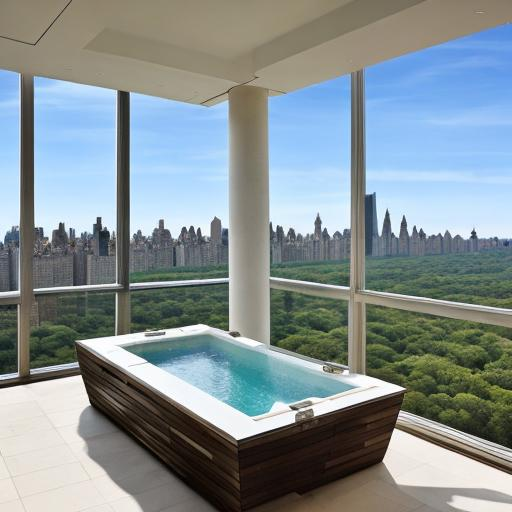

CPU times: user 29.4 ms, sys: 871 µs, total: 30.3 ms
Wall time: 2.75 s


In [60]:
%%time
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

# response = runtime_sm_client.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType="application/octet-stream",
#     Body=json.dumps(payload),
#     TargetModel="sd_base.tar.gz",
# )
# output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
# original_image = decode_image(output[0]["data"][0])
# original_image

original_image = invoke_endpoint(endpoint_name, payload, target_model="sd_base.tar.gz")
print("Original image")
display(original_image)

#### Image Style Transfer
Stable Diffusion base에서 생성한 이미지를 Depth 모델을 사용하여 다양한 이미지 스타일로 표현해 봅니다.

Oil painting


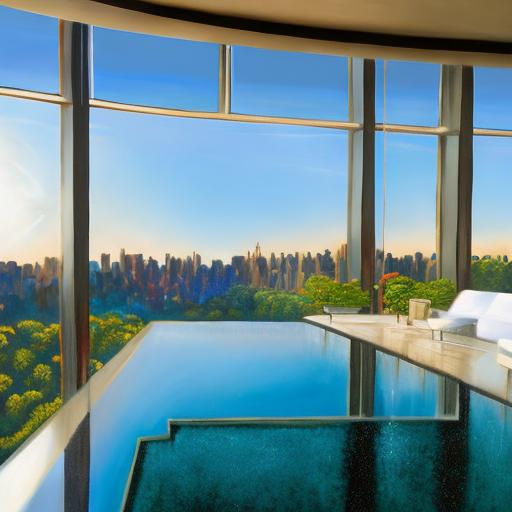

In [57]:
input_image = encode_image(original_image).decode("utf8")

inputs = dict(
    prompt="highly detailed oil painting of an inifinity pool overlooking central park",
    image=input_image,
    gen_args=json.dumps(dict(num_inference_steps=50, strength=0.8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

oil_painting = invoke_endpoint(endpoint_name, payload, target_model="sd_depth.tar.gz")
print("Oil painting")
display(oil_painting)

Yellowstone


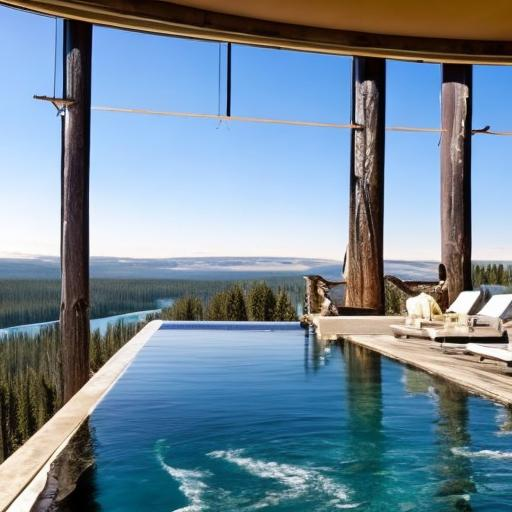

In [59]:
inputs = dict(
    prompt="Infinity pool perched on a cliff overlooking Yellowstone National Park ",
    image=input_image,
    gen_args=json.dumps(dict(num_inference_steps=50, strength=0.8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

rocky_mountains = invoke_endpoint(endpoint_name, payload, target_model="sd_depth.tar.gz")
print("Yellowstone")
display(rocky_mountains)

### Inpainting

source image


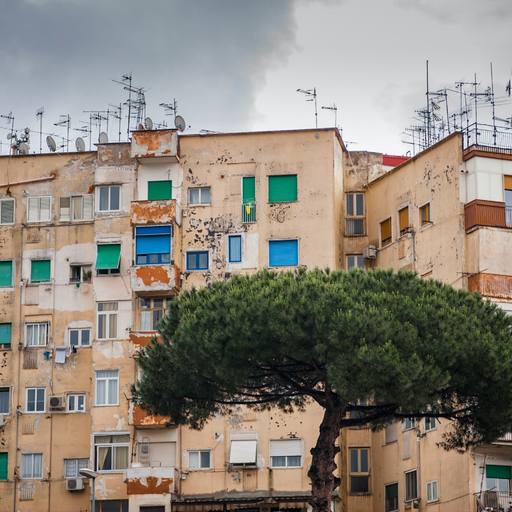

filled image


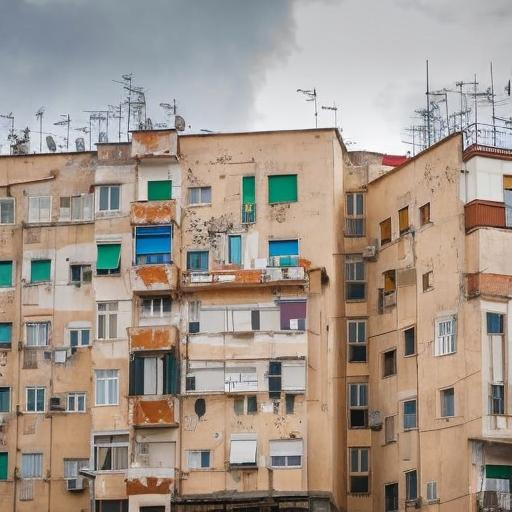

In [61]:
source_image = Image.open("sample_images/bertrand-gabioud.png")

image = encode_image(source_image).decode("utf8")
mask_image = encode_image(Image.open("sample_images/bertrand-gabioud-mask.png")).decode("utf8")
inputs = dict(
    prompt="building, facade, paint, windows",
    image=image,
    mask_image=mask_image,
    negative_prompt="tree, obstruction, sky, clouds",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=10)),
)


payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

filled_image = invoke_endpoint(endpoint_name, payload, target_model="sd_inpaint.tar.gz")

print("source image")
display(source_image)

print("filled image")
display(filled_image)
#display(decode_image(output[0]["data"][0]))

#### Super resolution

원본 출력 이미지의 크기를 512x512에서 128x128로 축소합니다. 그런 다음 Stable Diffusion 업스케일링 모델을 사용하여 이미지를 원래 512 해상도로 다시 업스케일링합니다.

Low res image


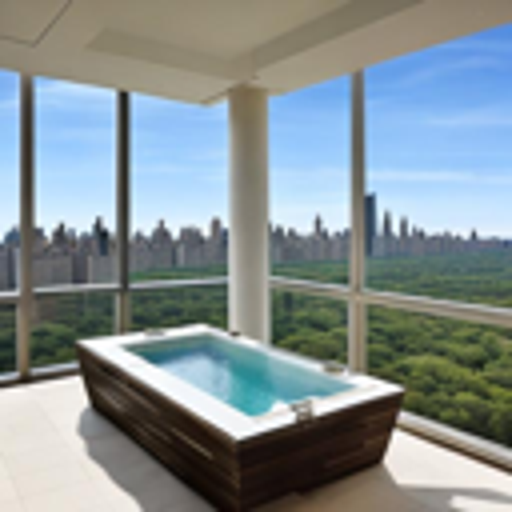

Upscaled image


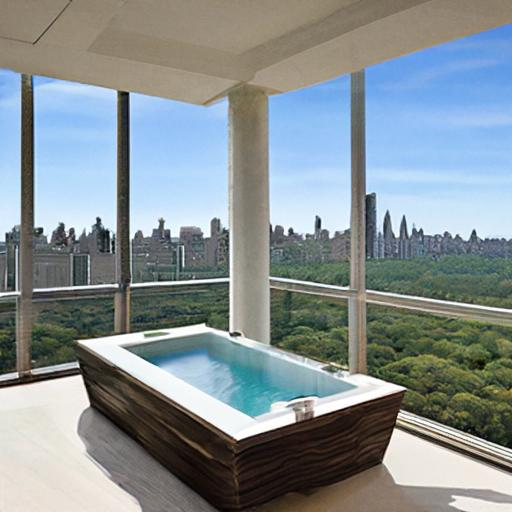

CPU times: user 61.5 ms, sys: 777 µs, total: 62.3 ms
Wall time: 27.9 s


In [62]:
%%time
low_res_image = original_image.resize((128, 128))
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    image=encode_image(low_res_image).decode("utf8"),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}


upscaled_image = invoke_endpoint(endpoint_name, payload, target_model="sd_upscale.tar.gz")

# response = runtime_sm_client.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType="application/octet-stream",
#     Body=json.dumps(payload),
#     TargetModel="sd_upscale.tar.gz",
# )
# output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
#upscaled_image = decode_image(output[0]["data"][0])

print("Low res image")
display(low_res_image.resize((512, 512)))

print("Upscaled image")
display(upscaled_image)

## Clean up <a name="query"></a>

In [65]:
from utils.lib import delete_endpoint
delete_endpoint(sm_client, endpoint_name)

--- Deleted model: stable-diffusion-mme-mdl-2023-08-14-23-08-30
--- Deleted endpoint_config: stable-diffusion-mme-epc-2023-08-14-23-08-30
--- Deleted endpoint: stable-diffusion-mme-ep-2023-08-14-23-08-30


In [66]:
# delete models in respective paths
for model_name, model_local_path in models_local_path.items():
    print(model_local_path)
    !rm -rf $model_local_path

models/sd_base/1/checkpoint
models/sd_depth/1/checkpoint
models/sd_inpaint/1/checkpoint
models/sd_upscale/1/checkpoint
